In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import auc, roc_curve, classification_report, roc_auc_score, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score
from sklearn.neighbors import KNeighborsClassifier 
from heapq import nsmallest
from sklearn.naive_bayes import GaussianNB

#Task 1
Подготовьте данные, уберите аномалии. 
Разбейте выборку, 
Проведите обучение моделей (KNN, DTC, NB, SVM, LR), 
Поищите гиперпараметры, 
Оцените их качество работы. 
Свои действия снабжайте пояснениями.

In [ ]:
water_dataframe = pd.read_csv('water_potability.csv')
water_dataframe = water_dataframe.dropna()

In [ ]:
water_dataframe = water_dataframe.sample(frac=1)
water_dataframe.head(5)

ph    Hardness        Solids  Chloramines     Sulfate  \
3136  6.579185  186.986869  16700.034873     6.454925  379.040709   
556   9.049166  169.509254   4343.356611     5.780823  386.700463   
1416  6.966835  158.043065  12256.678287     7.105619  371.517435   
1351  8.647454  183.597374  12995.885427     6.195449  382.357869   
381   6.512901  169.217480  25151.411574     4.613311  375.612318   

      Conductivity  Organic_carbon  Trihalomethanes  Turbidity  Potability  
3136    405.276912       14.996029        62.152315   3.813556           1  
556     471.925377       16.170628        62.722085   2.814001           0  
1416    382.443863       14.408080        78.100735   2.957441           0  
1351    489.762799       18.076963        93.409614   3.624101           0  
381     296.074382       15.088700        74.075926   4.404040           1

##Очистка данных от аномалий. Балансировка выборки

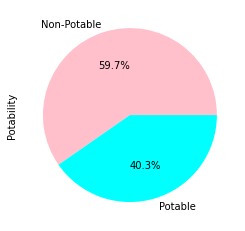

In [ ]:
labels = 'Non-Potable', 'Potable' 
colors = ['pink', 'cyan']
water_dataframe.Potability.value_counts().plot(kind = 'pie', labels = labels, autopct='%1.1f%%', colors=colors) #соотношение примерно 6 к 4. Выборка сбалансирована

In [ ]:
water_dataframe.describe() #так как все признаки в датафрейме вещественные, то для "детекта" выбросов достаточно использовать функцию 
#describe(). Видно, что выбросы есть практически у каждого признака(максимальное значение превышает третий квартиль на большие величины, либо
#минимальное значение сильно меньше первого квартиля)

ph     Hardness        Solids  Chloramines      Sulfate  \
count  2011.000000  2011.000000   2011.000000  2011.000000  2011.000000   
mean      7.085990   195.968072  21917.441374     7.134338   333.224672   
std       1.573337    32.635085   8642.239815     1.584820    41.205172   
min       0.227499    73.492234    320.942611     1.390871   129.000000   
25%       6.089723   176.744938  15615.665390     6.138895   307.632511   
50%       7.027297   197.191839  20933.512750     7.143907   332.232177   
75%       8.052969   216.441070  27182.587067     8.109726   359.330555   
max      14.000000   317.338124  56488.672413    13.127000   481.030642   

       Conductivity  Organic_carbon  Trihalomethanes    Turbidity   Potability  
count   2011.000000     2011.000000      2011.000000  2011.000000  2011.000000  
mean     426.526409       14.357709        66.400859     3.969729     0.403282  
std       80.712572        3.324959        16.077109     0.780346     0.490678  
min      201.619737        2.200000         8.577013     1.450000     0.000000  
25%      366.680307       12.124105        55.952664     3.442915     0.000000  
50%      423.455906       14.322019        66.542198     3.968177     0.000000  
75%      482.373169       16.683049        77.291925     4.514175     1.000000  
max      753.342620       27.006707       124.000000     6.494749     1.000000

In [ ]:
#Решение: установить порог для максимального значения признака и для минимального . Иначе - выбросить данный объект из датафрейма

In [ ]:
Q_1 = {} #объявляем словари для минимального и максимального значения
Q_3 = {}
for elem in water_dataframe.describe().drop(columns=['Potability']).columns:
  Q_1[elem] = water_dataframe.describe().iloc[4][elem] #записываем в словарь значения первого квартиля
  Q_3[elem] = water_dataframe.describe().iloc[6][elem] #записываем в словарь значения третьего квартиля

In [ ]:
for elem in water_dataframe.describe().drop(columns=['Potability']).columns:
  water_dataframe = water_dataframe[water_dataframe[elem] < (Q_3[elem] + (0.439 * Q_3[elem]))]
  water_dataframe = water_dataframe[water_dataframe[elem] > (Q_1[elem] - (0.495 * Q_1[elem]))]
  #print(water_dataframe.loc[i][elem])

In [ ]:
water_dataframe.describe()

ph     Hardness        Solids  Chloramines      Sulfate  \
count  1784.000000  1784.000000   1784.000000  1784.000000  1784.000000   
mean      7.098621   195.581447  21305.953265     7.144715   334.037324   
std       1.476457    31.566892   7185.204836     1.459044    39.288872   
min       3.148712    94.091307   7907.330441     3.117441   187.424131   
25%       6.110177   176.921378  15715.740730     6.185942   309.230458   
50%       7.034491   197.076345  20473.847706     7.138343   333.044572   
75%       8.029650   215.431708  26476.413758     8.083132   359.141540   
max      11.563169   306.627481  39030.603705    11.543190   481.030642   

       Conductivity  Organic_carbon  Trihalomethanes    Turbidity   Potability  
count   1784.000000     1784.000000      1784.000000  1784.000000  1784.000000  
mean     427.210807       14.472336        66.640356     3.985440     0.395179  
std       80.423657        3.183521        15.418630     0.778080     0.489026  
min      201.619737        6.124625        28.566364     1.812529     0.000000  
25%      367.927117       12.256113        56.281209     3.449837     0.000000  
50%      423.850390       14.384537        66.583401     3.979666     0.000000  
75%      484.095410       16.801797        77.371974     4.531610     1.000000  
max      669.725086       23.917601       111.115310     6.494749     1.000000

In [ ]:
water_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1784 entries, 3136 to 801
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               1784 non-null   float64
 1   Hardness         1784 non-null   float64
 2   Solids           1784 non-null   float64
 3   Chloramines      1784 non-null   float64
 4   Sulfate          1784 non-null   float64
 5   Conductivity     1784 non-null   float64
 6   Organic_carbon   1784 non-null   float64
 7   Trihalomethanes  1784 non-null   float64
 8   Turbidity        1784 non-null   float64
 9   Potability       1784 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 153.3 KB


##Разбиение выборки на обучающую и тестовую

In [ ]:
Loss = ({'model' : [], 'test_accuracy' : [], 'test_recall' :[] , 'test_auc' :[]}) #заводим пустой датафрейм для хранения показателей метрик качества
df_Loss = pd.DataFrame(Loss)

In [ ]:
#Разбиваем выборку на обучающую тестовую
X = water_dataframe.drop(columns=['Potability'])
y = water_dataframe['Potability']
(X_train, X_test, 
y_train, y_test) = train_test_split(X, y, 
                                     test_size=0.3, 
                                     random_state=water_dataframe.shape[0], stratify = y)

In [ ]:
#Масштабируем признаки 
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
def loss_func(df, model, y_test, y_pred):  # функция для оценки качества обученной модели
  te_ac = accuracy_score(y_test, y_pred).round(4)
  te_rec = recall_score(y_test, y_pred).round(4)
  te_auc = roc_auc_score(y_test, y_pred).round(4)
  new_row = {'model' : model, 'test_accuracy' : te_ac, 'test_recall' : te_rec, 'test_auc' : te_auc}
  df = df.append(new_row, ignore_index = True)
  return df

#Обучение

##Обучение KNN-модели

In [ ]:
error_rates = [] #метод локтя. Обучаем модель с i значением гиперпараметра. 
for i in np.arange(1, 101):  
    new_model = KNeighborsClassifier(n_neighbors = i) 
    new_model.fit(X_train, y_train)
    new_predictions = new_model.predict(X_test)
    error_rates.append(np.mean(new_predictions != y_test)) #Усредняем количество ошибок

In [ ]:
best_n, best_n_2 = map(error_rates.index, nsmallest(2, error_rates)) #ищем индекс, под которыми стоят два элемент с минимальными средними ошибками
best_n += 1
best_n_2 += 1

In [ ]:
print(best_n, best_n_2)

23 25


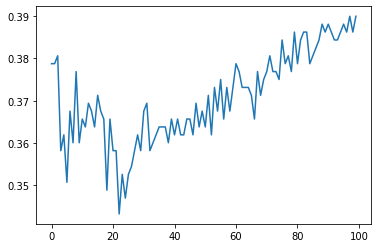

In [ ]:
plt.plot(error_rates) #отрисовка графика частоты ошибок метода KNN
 

In [ ]:
clf = KNeighborsClassifier(n_neighbors=best_n)
clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=23)

In [ ]:
 
#метрики качества, полнота, точность, f1  
y_pred_KNN = clf.predict(X_test)
print(confusion_matrix(y_test, y_pred_KNN))
print(classification_report(y_test, y_pred_KNN))
print(roc_auc_score(y_test, y_pred_KNN))
df_Loss = loss_func(df_Loss, 'KNN', y_test, y_pred_KNN)

[[300  24]
 [160  52]]
              precision    recall  f1-score   support

           0       0.65      0.93      0.77       324
           1       0.68      0.25      0.36       212

    accuracy                           0.66       536
   macro avg       0.67      0.59      0.56       536
weighted avg       0.66      0.66      0.61       536

0.5856044723969251


In [ ]:
df_Loss

model  test_accuracy  test_recall  test_auc
0   KNN         0.6567       0.2453    0.5856

##Обучение классификатора дерева решений(DTC)


In [ ]:
from sklearn import tree
error_rates = [] #метод локтя, логика аналогична методу KNN
for i in np.arange(1, 101):
    new_model = tree.DecisionTreeClassifier(max_depth = i)
    new_model.fit(X_train, y_train)
    new_predictions = new_model.predict(X_test)
    error_rates.append(np.mean(new_predictions != y_test))

In [ ]:
best_n, p = map(error_rates.index, nsmallest(2, error_rates)) #ищем индекс, под которыми стоят два элемент с минимальными средними ошибками
best_n += 1

In [ ]:
print(best_n)

4


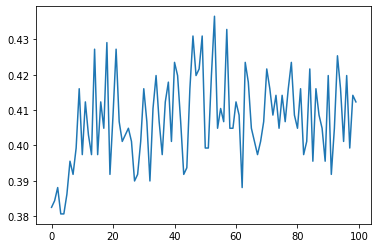

In [ ]:
plt.plot(error_rates) #отрисовка графика частоты ошибок метода DTC

In [ ]:
from sklearn import tree
clf_tree = tree.DecisionTreeClassifier(max_depth = best_n)
clf_tree = clf_tree.fit(X_train, y_train)
y_pred_tree = clf_tree.predict(X_test)
print(confusion_matrix(y_test, y_pred_tree)) #метрики качества
print(classification_report(y_test, y_pred_tree))
print(roc_auc_score(y_test, y_pred_tree))
df_Loss = loss_func(df_Loss, 'DTC', y_test, y_pred_tree)

[[302  22]
 [181  31]]
              precision    recall  f1-score   support

           0       0.63      0.93      0.75       324
           1       0.58      0.15      0.23       212

    accuracy                           0.62       536
   macro avg       0.61      0.54      0.49       536
weighted avg       0.61      0.62      0.54       536

0.5391625902632192


In [ ]:
df_Loss

model  test_accuracy  test_recall  test_auc
0   KNN         0.6567       0.2453    0.5856
1   DTC         0.6213       0.1462    0.5392

##Обучение наивного байесовского классификатора (Naive Bayes)

In [ ]:
clf_Gaussian = GaussianNB() #некорректно работает, если методом локтя подбирать гиперпараметры
clf_Gaussian.fit(X_train, y_train)

GaussianNB()

In [ ]:
y_pred_Gaus = clf_Gaussian.predict(X_test)
print(confusion_matrix(y_test, y_pred_Gaus))
print(classification_report(y_test, y_pred_Gaus))
print(roc_auc_score(y_test, y_pred_Gaus))
df_Loss = loss_func(df_Loss, 'Naive Bayes', y_test, y_pred_Gaus)

[[275  49]
 [169  43]]
              precision    recall  f1-score   support

           0       0.62      0.85      0.72       324
           1       0.47      0.20      0.28       212

    accuracy                           0.59       536
   macro avg       0.54      0.53      0.50       536
weighted avg       0.56      0.59      0.54       536

0.5257978103890053


In [ ]:
df_Loss

model  test_accuracy  test_recall  test_auc
0          KNN         0.6567       0.2453    0.5856
1          DTC         0.6213       0.1462    0.5392
2  Naive Bayes         0.5933       0.2028    0.5258

##Обучение методом опорных векторов (Support Vector Machines)


In [ ]:
from sklearn import svm
clf_SVM = svm.SVC()
clf_SVM.fit(X_train, y_train)

SVC()

In [ ]:
y_pred_SVM = clf_SVM.predict(X_test)
print(confusion_matrix(y_test, y_pred_SVM))
print(classification_report(y_test, y_pred_SVM))
print(roc_auc_score(y_test, y_pred_SVM))
df_Loss = loss_func(df_Loss, 'SVM', y_test, y_pred_SVM)

[[294  30]
 [143  69]]
              precision    recall  f1-score   support

           0       0.67      0.91      0.77       324
           1       0.70      0.33      0.44       212

    accuracy                           0.68       536
   macro avg       0.68      0.62      0.61       536
weighted avg       0.68      0.68      0.64       536

0.6164395527603075


In [ ]:
df_Loss

model  test_accuracy  test_recall  test_auc
0          KNN         0.6567       0.2453    0.5856
1          DTC         0.6213       0.1462    0.5392
2  Naive Bayes         0.5933       0.2028    0.5258
3          SVM         0.6772       0.3255    0.6164

##Обучение модели логистической регрессии (Logistic Regression)

In [ ]:
from sklearn.linear_model import LogisticRegression
clf_Logistic = LogisticRegression(class_weight='balanced')
clf_Logistic.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [ ]:
y_pred_Log = clf_Logistic.predict(X_test)
print(confusion_matrix(y_test, y_pred_Log))
print(classification_report(y_test, y_pred_Log))
print(roc_auc_score(y_test, y_pred_Log))
df_Loss = loss_func(df_Loss, 'Logistic Regression', y_test, y_pred_Log) #линейная зависимость в данных отсутствует. Логистическая регрессия здесь бесполезна

[[159 165]
 [116  96]]
              precision    recall  f1-score   support

           0       0.58      0.49      0.53       324
           1       0.37      0.45      0.41       212

    accuracy                           0.48       536
   macro avg       0.47      0.47      0.47       536
weighted avg       0.49      0.48      0.48       536

0.47178546470999294


In [ ]:
df_Loss

model  test_accuracy  test_recall  test_auc
0                  KNN         0.6567       0.2453    0.5856
1                  DTC         0.6213       0.1462    0.5392
2          Naive Bayes         0.5933       0.2028    0.5258
3                  SVM         0.6772       0.3255    0.6164
4  Logistic Regression         0.4757       0.4528    0.4718

#Визуализация результатов

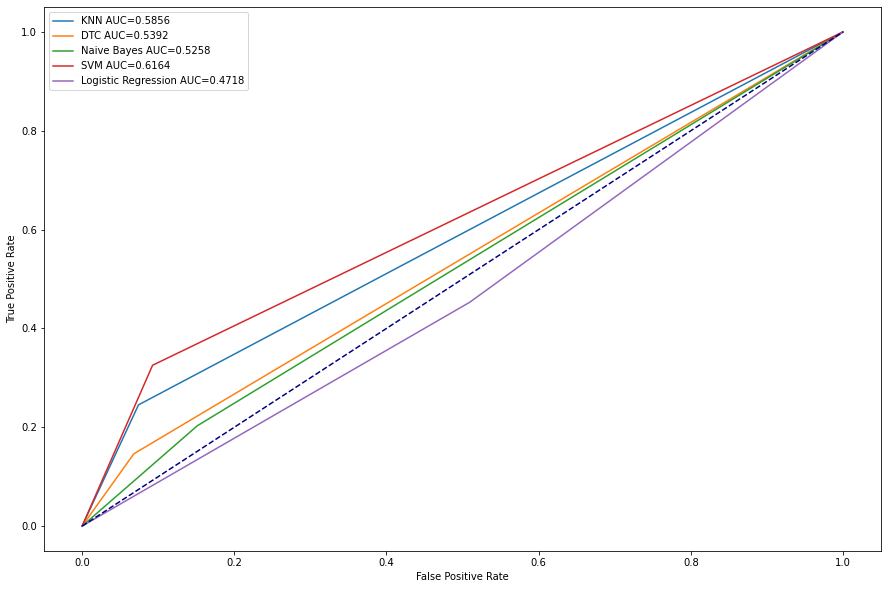

In [ ]:

plt.figure(figsize = (15,10)) # Для сравнения результатов работы моделей проведём визуализацию
models = ['KNN', 'DTC', 'Naive Bayes', 'SVM', 'Logistic Regression']
y_predicts = []
y_predicts.append(y_pred_KNN)
y_predicts.append(y_pred_tree)
y_predicts.append(y_pred_Gaus)
y_predicts.append(y_pred_SVM)
y_predicts.append(y_pred_Log)

for i in range(len(y_predicts)):
    fpr, tpr, _ = roc_curve(y_test, y_predicts[i])
    auc = roc_auc_score(y_test, y_predicts[i])
    lw = 1.5
    plt.plot(fpr,tpr,label=str(models[i])+" AUC="+str(auc.round(4)),lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=0)
plt.show()

In [ ]:
df_Loss #итоговый датасет с метриками качества

model  test_accuracy  test_recall  test_auc
0                  KNN         0.6567       0.2453    0.5856
1                  DTC         0.6213       0.1462    0.5392
2          Naive Bayes         0.5933       0.2028    0.5258
3                  SVM         0.6772       0.3255    0.6164
4  Logistic Regression         0.4757       0.4528    0.4718